Raw data: Kaggle+Tweet

沒有做shuffle(Tweet維持在最後面)

有保留EDA

In [1]:
# Data Analysis
import re
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
%matplotlib inline
sns.set_theme()

# Dimension reduction and embedding
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

# Model training and evaluation
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Text Processing 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# Other
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import classification_report

# NLTK resource
import nltk
# nltk.download('punkt')  # for word_tokenize
# nltk.download('wordnet')  # for WordNetLemmatizer
# nltk.download('omw-1.4')
# nltk.download('stopwords')

## 1: EDA

In [6]:
data = pd.read_csv('../data/kaggle+twitter.csv', index_col=[0]).dropna().reset_index(drop=True)
data.shape

(8775, 2)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8775 entries, 0 to 8774
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8775 non-null   object
 1   flat    8775 non-null   object
dtypes: object(2)
memory usage: 137.2+ KB


In [4]:
data.tail()

,type,flat
8770,ISFP,fight ensur power medium corpor planet treat f...
8771,ISFP,face_with_tears_of_joy sign_of_the_horns_mediu...
8772,INTJ,cst___ video light venu everyth power realli a...
8773,INFJ,support affect elementari school shoot uvald t...
8774,ENFP,hear someon open bag chip year marriag handsom...


由於 Twitter 的資料在最後面，我把他打亂並重設 index

In [7]:
data_shuffle = data.sample(frac=1, random_state=42).reset_index(drop=True)
data_shuffle

,type,flat
0,INFJ,phobic weari men feminist misogynist take pers...
1,INTJ,say necessarili know one harm sex problem bit ...
2,INFP,usual claim good decis decid order go day frie...
3,ENFJ,yeah friend relationship work togeth never met...
4,ENTP,sound like typic trait role se h fe lack ethic...
...,...,...
8770,INFJ,correct went troubl becom dish end irrespect d...
8771,ENFP,trick know valu know passion find group peopl ...
8772,INFP,ok talk friend age lot late go pose question f...
8773,INFP,even loner get lone feel like hard hard relati...


In [ ]:
# There are many records contains URL
search_URL = data.loc[data['posts'].str.contains("www", case=True)]
search_URL

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8667,ENTP,'I think generally people experience post trau...
8669,INFJ,'I'm not sure about a method for picking out I...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8672,INTP,'So many questions when i do these things. I ...


In [10]:
# Data distribution of 16 types
n_colors=16
color = px.colors.sample_colorscale('Purpor_r', [n/(n_colors -1) for n in range(n_colors)])
df_count = data['type'].value_counts()
df_count = df_count.rename_axis('type').reset_index(name='counts')
fig = px.bar(df_count, x='type', y='counts',
            color='type', color_discrete_sequence=color,
            # opacity=0.7,
            title='Type count (Kaggle+Twitter)',
            width=1000,
            height=600)
fig.show()

In [11]:
def WordCount(sentence: str):
    stripped = sentence.strip()  # str
    # print(type(stripped))
    splitted = stripped.split(' ')  # list
    # print(type(splitted))
    return len(splitted)

In [12]:
# Distribution of Lengths of all Posts
data_wordcount = data['flat'].apply(WordCount)
fig = px.histogram(data_wordcount, x='flat',
                title='Distribution of Lengths of all Posts',
                color_discrete_sequence=["lightsteelblue"],
                labels={"flat": "words"},
                width=1000, height=600)
fig.update_traces(marker_line_width=1, marker_line_color="white")
fig.show()

後來發現推特的資料都很多字數

In [13]:
std_left = data_wordcount.mean() - 3*np.std(data_wordcount)
std_right = data_wordcount.mean() + 3*np.std(data_wordcount)
print(max(0,std_left), std_right)

0 7841.277378877923


In [14]:
data[data_wordcount>std_right]

,type,flat
8674,ESFP,puppi music thing put good mood play theatr ge...
8675,INFP,piec peac victory_hand dof peace_symbol soulca...
8676,ISTP,virtual hill present allow fan sit hill creat ...
8677,ENFJ,like much social medium presenc autocorrect co...
8678,ISFP,kansa citi black_heart orange_heart lie nreven...
...,...,...
8770,ISFP,fight ensur power medium corpor planet treat f...
8771,ISFP,face_with_tears_of_joy sign_of_the_horns_mediu...
8772,INTJ,cst___ video light venu everyth power realli a...
8773,INFJ,support affect elementari school shoot uvald t...


In [15]:
data_wordcount[8674:]

8674    19825
8675    33968
8676    25095
8677    12031
8678    21884
        ...  
8770    12988
8771    13509
8772    18792
8773    15456
8774    21288
Name: flat, Length: 101, dtype: int64

## 2: Text Preprocessing

In [ ]:
def Preprocessor(text:str, remove_mbti: bool=True) -> list:
	'''
	Input: str
	Output: list
		Preprocessed tokens
	remove_mbti: bool
		Remove MBTI keywords like INTJ, ENFP, etc. Default is True)
	'''
	# Cleaning
	text = re.sub(r'\|\|\|', ' ', text)  # Split by separator
	text = re.sub(r'http\S+', ' ', text)  # Replace hyperlink
	text = re.sub(r"[A-Za-z]+\'+\w+", ' ', text)  # Handling apostrophe (e.g. you've, there's)
	text = re.sub('[^a-zA-Z]',' ', text)  # Keep only numbers and alphabets (remove special characters)
	text = text.lower()
	if remove_mbti == True:
		text = re.sub('intj|intp|entj|entp|infp|enfj|enfp|istj|isfj|estj|esfj|istp|isfp|estp|esfp|infj', '', text)
  	# Tokenization
	tokens = word_tokenize(text)
	filtered_tokens = [w for w in tokens if not w in stopwords.words('english')]  # Remove stopwords
	# Stemming
	stemmer_ = SnowballStemmer("english")
	stemmed = [stemmer_.stem(t) for t in filtered_tokens]
	# Lemmatizing
	lemma = WordNetLemmatizer()
	lemmatized = [lemma.lemmatize(t) for t in stemmed]
	return lemmatized

## 3: Word Cloud
Create Word Cloud of 16 types based on preprocessed tokens

In [16]:
# Tokens group by type
df_multi_word = data.groupby(['type'])['flat'].apply(lambda x: ' '.join(x)).reset_index()
df_multi_word

,type,flat
0,ENFJ,went break month ago togeth year plan life aro...
1,ENFP,want go trip without stay behind option think ...
2,ENTJ,fire anoth silli misconcept approach logic go ...
3,ENTP,find lack post alarm sex bore posit often exam...
4,ESFJ,origin mistyp nfp think increas common across ...
5,ESFP,edit forgot board current read artemi fowl ete...
6,ESTJ,catch although quit terribl fi develop rapid r...
7,ESTP,splinter cell blacklist xbox general well like...
8,INFJ,moment sportscent top ten play prank life chan...
9,INFP,think agre person consid alpha beta foxtrot lo...


In [17]:
df_multi_word['flat'].apply(WordCount)

0      153670
1      464201
2      208035
3      622821
4      235499
5      455645
6      129395
7      151308
8      928811
9     1155222
10     665282
11     791419
12     167616
13     458872
14     165514
15     433644
Name: flat, dtype: int64

WordCloud

In [18]:
def getSortFreqDictForText(sentence)->dict:
    # making dict for counting frequencies
    dict_freq = {}
    for word in sentence.split(" "):
        freq = dict_freq.get(word, 0)  # specify the default value
        dict_freq[word] = freq + 1
    # sort by frequency
    result = dict(sorted(dict_freq.items(), key=lambda item: item[1], reverse=True))
    return result

In [19]:
def createWordCloud(freq_dict: dict):
    '''
    Input: Frequency dictionary
    Outpue: Word cloud object
    Default max_words is 500.
    '''
    wc = WordCloud(background_color="white", colormap='tab20c',
                   max_words=500, width=600, height=400,
                   stopwords=None,
                   prefer_horizontal=1.0)
    return wc.generate_from_frequencies(freq_dict)

In [20]:
# Create dictionary with frequency
df_multi_word['freq_dict'] = df_multi_word['flat'].apply(getSortFreqDictForText)
df_multi_word

,type,flat,freq_dict
0,ENFJ,went break month ago togeth year plan life aro...,"{'love': 2014, 'like': 2004, 'think': 1489, 'p..."
1,ENFP,want go trip without stay behind option think ...,"{'like': 6940, 'think': 4838, 'peopl': 3886, '..."
2,ENTJ,fire anoth silli misconcept approach logic go ...,"{'like': 2288, 'think': 1744, 'get': 1546, 'on..."
3,ENTP,find lack post alarm sex bore posit often exam...,"{'like': 6750, 'think': 5031, 'one': 4459, 'ge..."
4,ESFJ,origin mistyp nfp think increas common across ...,"{'love': 2223, 'amp': 1770, 'thank': 1726, 'ne..."
5,ESFP,edit forgot board current read artemi fowl ete...,"{'amp': 3520, 'de': 3212, 'love': 2641, 'thank..."
6,ESTJ,catch although quit terribl fi develop rapid r...,"{'new': 1182, 'today': 1090, 'see': 1026, 'get..."
7,ESTP,splinter cell blacklist xbox general well like...,"{'get': 1329, 'like': 1296, 'go': 1052, 'amp':..."
8,INFJ,moment sportscent top ten play prank life chan...,"{'like': 13268, 'think': 10409, 'peopl': 8507,..."
9,INFP,think agre person consid alpha beta foxtrot lo...,"{'like': 17518, 'think': 13279, 'feel': 10450,..."


In [21]:
multi_type_list = df_multi_word['type'].unique()

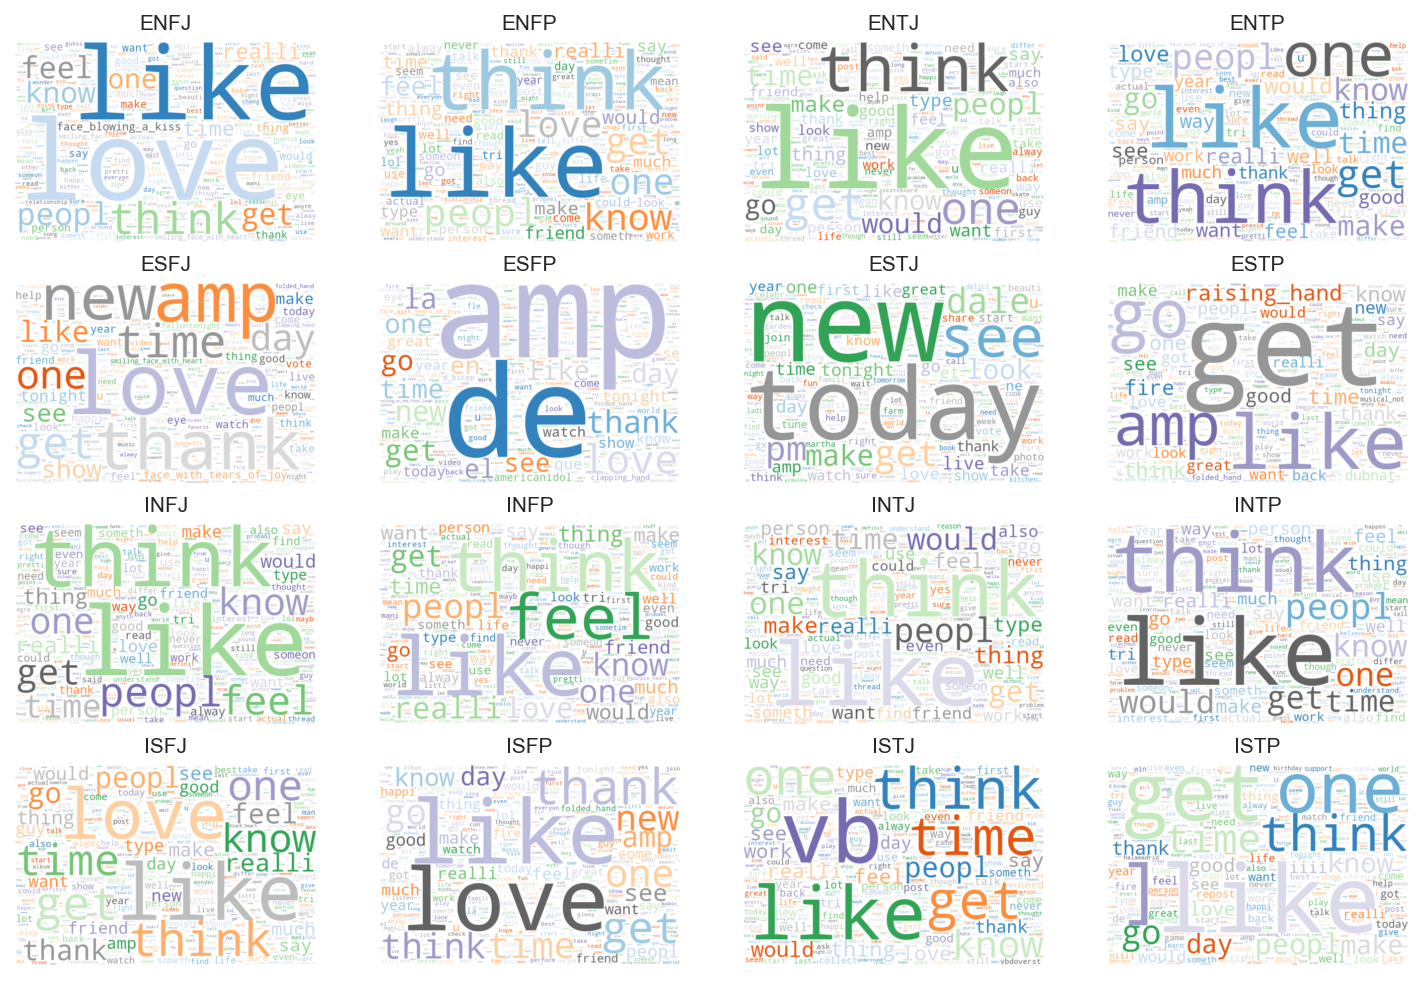

In [22]:
fig = plt.figure(figsize=(12,8), dpi=150)
for idx, mbti in enumerate(multi_type_list):
    ax = fig.add_subplot(4, 4, idx+1)
    freq_dict = getSortFreqDictForText(df_multi_word['flat'][idx])
    wordcloud = createWordCloud(freq_dict)
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis('off')
    ax.set_title(mbti, fontsize=10)
fig.show()
fig.savefig('../img/wordcloud_tweet_kaggle.png')


## 4: Feature engineering

### TF-IDF

不設任何限制的 Tf-IDf 會有 78195 個 features

In [23]:
vectorizer = TfidfVectorizer(analyzer="word",
                          max_features=None,
                          lowercase=None,
                          ngram_range=(1,1)).fit(data['flat'])
X_tfidf = vectorizer.transform(data['flat'])
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names())
df_tfidf

,__,___,____,_____,______,_______,________,_________,__________,___________,...,𝙬𝙞𝙡𝙡,𝙬𝙞𝙩𝙝,𝙬𝙤𝙧𝙠,𝙭𝙞𝙢𝙤,𝙮𝙤𝙪,𝙰𝙻𝙱,𝙴𝙻𝙻𝙰,𝙷𝙴,𝙼𝙾𝙽,𝙾𝙵
0,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8770,0.0,0.00000,0.0,0.002447,0.002488,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8771,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8772,0.0,0.00233,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8773,0.0,0.00000,0.0,0.000000,0.002489,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


查看 TF-IDF 最高的 terms

In [24]:
# top 50 words in entire corpus
reverse_dic = {}
for key in vectorizer.vocabulary_:
    reverse_dic[vectorizer.vocabulary_[key]] = key
top_tfidf = np.asarray(np.argsort(np.sum(X_tfidf, axis=0))[0,-100:][0, ::-1]).flatten()
[reverse_dic[v] for v in top_tfidf]

['like',
 'think',
 'peopl',
 'know',
 'get',
 'one',
 'feel',
 'realli',
 'would',
 'thing',
 'time',
 'type',
 'go',
 'love',
 'say',
 'make',
 'want',
 'person',
 'friend',
 'well',
 'much',
 'see',
 'way',
 'good',
 'tri',
 'someth',
 'lot',
 'also',
 'use',
 'thank',
 'work',
 'alway',
 'even',
 'seem',
 'someon',
 'look',
 'find',
 'life',
 'year',
 'though',
 'read',
 'never',
 'post',
 'need',
 'could',
 'actual',
 'talk',
 'interest',
 'thought',
 'mean',
 'take',
 'yes',
 'pretti',
 'sure',
 'come',
 'lol',
 'right',
 'guy',
 'first',
 'day',
 'differ',
 'thread',
 'help',
 'got',
 'sometim',
 'relationship',
 'still',
 'said',
 'start',
 'understand',
 'mani',
 'probabl',
 'emot',
 'kind',
 'mayb',
 'yeah',
 'ask',
 'question',
 'usual',
 'best',
 'tell',
 'function',
 'around',
 'back',
 'point',
 'definit',
 'give',
 'sound',
 'happi',
 'live',
 'anyth',
 'littl',
 'agre',
 'quit',
 'mind',
 'world',
 'might',
 'test',
 'long',
 'guess']

### TruncatedSVD
計算出 100 個奇異值最大的值

In [25]:
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42).fit(X_tfidf)
X_svd = svd.transform(X_tfidf)
X_svd.shape

(8775, 100)

In [26]:
df_svd = pd.DataFrame(X_svd)
df_svd

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.229545,-0.028989,-0.045965,0.066401,-0.057249,0.079097,0.003809,0.032545,-0.009981,0.038963,...,0.047942,-0.003039,0.025085,-0.003573,-0.028684,-0.009696,0.034604,-0.005030,0.000165,0.019974
1,0.360610,0.012479,-0.000341,0.022311,-0.006086,0.034989,-0.060039,-0.010693,-0.040258,-0.011648,...,-0.034129,0.019666,0.011361,0.005514,0.004656,0.017570,-0.025699,-0.009809,-0.034064,0.006135
2,0.327312,-0.030932,-0.040444,0.026457,-0.027842,0.053574,-0.016264,-0.024196,-0.007087,-0.001755,...,-0.029566,0.023086,-0.002056,0.020637,0.031999,0.014085,0.018036,-0.031404,0.002175,-0.009348
3,0.386921,0.149635,-0.024355,0.000864,-0.044895,-0.022474,0.024644,0.058983,0.065785,-0.054280,...,-0.013632,-0.036435,0.003184,-0.009214,0.032208,-0.022307,0.002965,0.021801,-0.014669,-0.017300
4,0.311343,-0.012648,-0.029449,0.000101,-0.058068,-0.067997,0.012178,0.038261,-0.059940,-0.069102,...,0.008758,-0.032844,-0.012204,-0.008233,0.005424,-0.001805,0.005271,-0.002694,-0.014487,0.001708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8770,0.145919,-0.076365,-0.018976,0.087926,-0.055274,0.158287,-0.065969,-0.140306,0.064675,-0.060021,...,0.002018,0.006957,0.011498,0.010748,0.004913,0.004569,0.002384,0.009638,-0.006296,-0.005959
8771,0.309006,-0.162712,0.062649,0.110748,-0.051533,0.229403,-0.076641,-0.190599,0.077341,-0.136733,...,0.013886,-0.008687,0.009657,0.007732,-0.012953,0.002135,0.008723,0.002487,0.010933,0.047774
8772,0.215972,-0.078943,-0.026046,0.103469,-0.076078,0.146511,-0.085873,-0.130796,0.047913,-0.072206,...,0.008163,0.022975,0.012728,0.005514,-0.015126,-0.004535,0.017213,-0.012559,-0.012908,0.032300
8773,0.190529,-0.091660,-0.009058,0.090704,-0.065729,0.151337,-0.076254,-0.135033,0.059795,-0.093560,...,0.011487,0.034607,0.003709,-0.003302,-0.033074,0.001585,0.012416,0.001121,-0.006924,0.032517


In [27]:
# Store SVD to csv
df_svd.to_csv('../data/Kaggle_MBTI_tweet_X_svd.csv', index=False)

## Binary Classification

In [28]:
def get_types(row):
    t=row['type']

    I = 0; N = 0
    T = 0; J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0

    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

data_labeled = data.join(data.apply (lambda row: get_types (row),axis=1))
data_labeled

,type,flat,IE,NS,TF,JP
0,INFJ,moment sportscent top ten play prank life chan...,1,1,0,1
1,ENTP,find lack post alarm sex bore posit often exam...,0,1,1,0
2,INTP,good one cours say know bless cur absolut posi...,1,1,1,0
3,INTJ,dear enjoy convers day esoter gab natur univer...,1,1,1,1
4,ENTJ,fire anoth silli misconcept approach logic go ...,0,1,1,1
...,...,...,...,...,...,...
8770,ISFP,fight ensur power medium corpor planet treat f...,1,0,0,0
8771,ISFP,face_with_tears_of_joy sign_of_the_horns_mediu...,1,0,0,0
8772,INTJ,cst___ video light venu everyth power realli a...,1,1,1,1
8773,INFJ,support affect elementari school shoot uvald t...,1,1,0,1


In [29]:
# Store data with labeled to csv
data_labeled.to_csv('../data/Kaggle_MBTI_twitter_labeled.csv', index=False)

In [243]:
# # Load labeled data
# data_labeled = pd.read_csv('../data/Kaggle_MBTI_twitter_labeled.csv')

In [30]:
# Plotting Classification class vs Frequency plot for IE, NS, TF, JP
I,N,T,J = data_labeled['IE'].value_counts()[0], data_labeled['NS'].value_counts()[0], data_labeled['TF'].value_counts()[0], data_labeled['JP'].value_counts()[0]
E,S,F,P = data_labeled['IE'].value_counts()[1], data_labeled['NS'].value_counts()[1], data_labeled['TF'].value_counts()[1], data_labeled['JP'].value_counts()[1]

dimensions = ['Introversion-Extraversion','Intuition-Sensing','Thinking-Feeling','Judging-Perceiving']
all = len(data_labeled)

fig = go.Figure()
fig.add_trace(go.Bar(name='I,N,T,J', x=dimensions, y=(I,N,T,J), customdata=[I/all,N/all,T/all,J/all], marker=dict(color=px.colors.qualitative.Pastel1[1])))
fig.add_trace(go.Bar(name='E,S,F,P', x=dimensions, y=(E,S,F,P), customdata=[E/all,S/all,F/all,P/all], marker=dict(color=px.colors.qualitative.Pastel1[3])))
fig.update_layout(barmode='group',title_text="Classification class vs Frequency plot", width=800)
fig.update_traces(hovertemplate='Actual: %{value}<br>Percent: %{customdata:,.2f}')
fig.show()

#### 相關係數
An assumption made in our model is that each letter type is independent of other types i.e. A person’s introversion/extroversion is not related to their judgement/perception. Nevertheless, we want to still test them below using a heat map

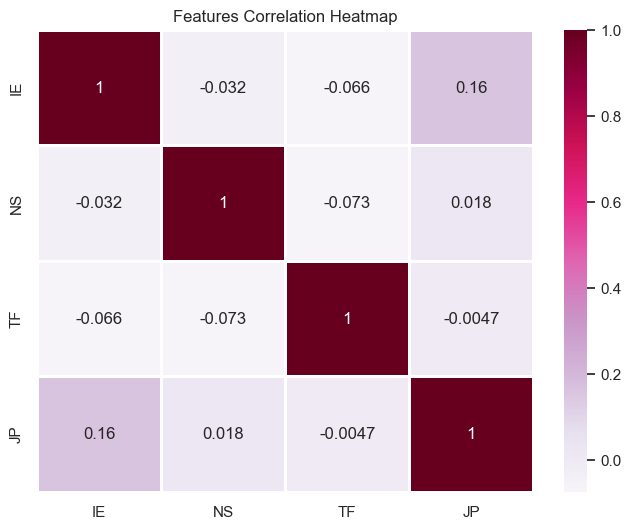

In [31]:
corr = data_labeled[['IE','NS','TF','JP']].corr()
plt.figure(figsize=(8,6))
plt.title('Features Correlation Heatmap', size=12)
sns.heatmap(corr,cmap=plt.cm.PuRd,annot=True,linewidths=1)
plt.show()

#### Training and Testing Split

Only executive one time.

In [35]:
data_labeled

,type,flat,IE,NS,TF,JP
0,INFJ,moment sportscent top ten play prank life chan...,1,1,0,1
1,ENTP,find lack post alarm sex bore posit often exam...,0,1,1,0
2,INTP,good one cours say know bless cur absolut posi...,1,1,1,0
3,INTJ,dear enjoy convers day esoter gab natur univer...,1,1,1,1
4,ENTJ,fire anoth silli misconcept approach logic go ...,0,1,1,1
...,...,...,...,...,...,...
8770,ISFP,fight ensur power medium corpor planet treat f...,1,0,0,0
8771,ISFP,face_with_tears_of_joy sign_of_the_horns_mediu...,1,0,0,0
8772,INTJ,cst___ video light venu everyth power realli a...,1,1,1,1
8773,INFJ,support affect elementari school shoot uvald t...,1,1,0,1


In [56]:
# Train test split
X_train_IE, X_test_IE, Y_train_IE, Y_test_IE = train_test_split(X_svd, data_labeled['IE'], test_size=0.2, random_state=42, stratify=data_labeled['IE'])
X_train_NS, X_test_NS, Y_train_NS, Y_test_NS = train_test_split(X_svd, data_labeled['NS'], test_size=0.2, random_state=42, stratify=data_labeled['NS'])
X_train_TF, X_test_TF, Y_train_TF, Y_test_TF = train_test_split(X_svd, data_labeled['TF'], test_size=0.2, random_state=42, stratify=data_labeled['TF'])
X_train_JP, X_test_JP, Y_train_JP, Y_test_JP = train_test_split(X_svd, data_labeled['JP'], test_size=0.2, random_state=42, stratify=data_labeled['JP'])

In [ ]:
IE_dataset = {"X_train": X_train_IE, "X_test": X_test_IE, "Y_train": Y_train_IE, "Y_test": Y_test_IE}
NS_dataset = {"X_train": X_train_NS, "X_test": X_test_NS, "Y_train": Y_train_NS, "Y_test": Y_test_NS}
TF_dataset = {"X_train": X_train_TF, "X_test": X_test_TF, "Y_train": Y_train_TF, "Y_test": Y_test_TF}
JP_dataset = {"X_train": X_train_JP, "X_test": X_test_JP, "Y_train": Y_train_JP, "Y_test": Y_test_JP}

In [69]:
# # Store binary dataset to pickle
# import pickle
# dataset = {'IE':IE_dataset,'NS':NS_dataset,'TF':TF_dataset,'JP':JP_dataset}

# for idx, (k,v) in enumerate(dataset.items()):
#     path = '../data/ka_tw_'+str(k)+'.pickle'
#     with open(path, 'wb') as file:
#         pickle.dump(v, file)

In [248]:
# # Load dataset form pickle
# data_IE = pd.read_pickle('../data/ka_tw_IE.pickle')
# data_NS = pd.read_pickle('../data/ka_tw_NS.pickle')
# data_TF = pd.read_pickle('../data/ka_tw_TF.pickle')
# data_JP = pd.read_pickle('../data/ka_tw_JP.pickle')

# X_train_IE, X_test_IE, Y_train_IE, Y_test_IE = data_IE['X_train'], data_IE['X_test'], data_IE['Y_train'], data_IE['Y_test']
# X_train_NS, X_test_NS, Y_train_NS, Y_test_NS = data_NS['X_train'], data_NS['X_test'], data_NS['Y_train'], data_NS['Y_test']
# X_train_TF, X_test_TF, Y_train_TF, Y_test_TF = data_TF['X_train'], data_TF['X_test'], data_TF['Y_train'], data_TF['Y_test']
# X_train_JP, X_test_JP, Y_train_JP, Y_test_JP = data_JP['X_train'], data_JP['X_test'], data_JP['Y_train'], data_JP['Y_test']

In [81]:
print(f'Each dataset:\nTrain|| X:{X_train_IE.shape}\tY:{Y_train_IE.shape} \nTest || X:{X_test_IE.shape}\tY:{Y_test_IE.shape}\n')

Each dataset:
Train|| X:(7020, 100)	Y:(7020,) 
Test || X:(1755, 100)	Y:(1755,)



#### Model method

In [110]:
def fitCV(model):
    '''
    Input: Base model
    Output: Models for each dimension
    '''
    # Cross validation
    grid1 = GridSearchCV(model,{},cv=10)
    grid2 = GridSearchCV(model,{},cv=10)
    grid3 = GridSearchCV(model,{},cv=10)
    grid4 = GridSearchCV(model,{},cv=10)
    # Fit
    model_IE = grid1.fit(X_train_IE,Y_train_IE)
    model_NS = grid2.fit(X_train_NS,Y_train_NS)
    model_TF = grid3.fit(X_train_TF,Y_train_TF)
    model_JP = grid4.fit(X_train_JP,Y_train_JP)

    return model_IE,model_NS,model_TF,model_JP

In [111]:
def predictCV(model_IE,model_NS,model_TF,model_JP):
    '''
    Input: 4 models
    Output: Predict on test data for each dimension
    '''
    ypredIE = model_IE.best_estimator_.predict(X_test_IE)
    ypredNS = model_NS.best_estimator_.predict(X_test_NS)
    ypredTF = model_TF.best_estimator_.predict(X_test_TF)
    ypredJP = model_JP.best_estimator_.predict(X_test_JP)
    return ypredIE, ypredNS, ypredTF, ypredJP

#### Evaluation method

In [84]:
def print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP):
   '''
   Function to print Classification Report of the given model
   This function takes 4 predicted output datasets as input.
   It computes classfication report: accuracy, recall, f1-score.
   It prints classification reports for all 4 predictions (models).
   '''
   print(f'Classification Report for Introversion(I) / Extroversion(E):\n {classification_report(Y_test_IE, ypredIE)}\n')
   print(f'Classification Report for Intuition(N) / Sensing(S):\n {classification_report(Y_test_NS, ypredNS)}\n')
   print(f'Classification Report for Thinking(T) / Feeling(F):\n{classification_report(Y_test_TF, ypredTF)}\n')
   print(f'Classification Report for Judging(J) / Perceiving(P):\n {classification_report(Y_test_JP, ypredJP)}\n')


def print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP):
   cm = confusion_matrix(Y_test_IE, ypredIE)
   plt.figure(figsize=(5,4))
   sns.heatmap(cm, annot=True,cmap='Reds_r',fmt='g')
   plt.ylabel('Y_test_IE')
   plt.xlabel('ypredIE')
   plt.title('Confusion matrix for Introversion(I) / Extroversion(E): ', size=12)

   cm = confusion_matrix(Y_test_NS, ypredNS)
   plt.figure(figsize=(5,4))
   sns.heatmap(cm, annot=True,cmap='Greens_r',fmt='g')
   plt.ylabel('Y_test_NS')
   plt.xlabel('ypredNS')
   plt.title('Confusion matrix for Intuition(N) / Sensing(S): ', size=12)

   cm = confusion_matrix(Y_test_TF, ypredTF)
   plt.figure(figsize=(5,4))
   sns.heatmap(cm, annot=True,cmap='Blues_r',fmt='g')
   plt.ylabel('Y_test_TF')
   plt.xlabel('ypredTF')
   plt.title('Confusion matrix for Thinking(T) / Feeling(F): ', size=12)

   cm = confusion_matrix(Y_test_JP, ypredJP)
   plt.figure(figsize=(5,4))
   sns.heatmap(cm, annot=True,cmap='Purples_r',fmt='g')
   plt.ylabel('Y_test_JP')
   plt.xlabel('ypredJP')
   plt.title('Confusion matrix for Judging(J) / Perceiving(P): ', size=12)


def print_roc_auc_curve(probIE, probNS, probTF, probJP, title:str):
   fp_IE, tp_IE, _ = roc_curve(Y_test_IE, probIE[:,1])
   fp_NS, tp_NS, _ = roc_curve(Y_test_NS, probNS[:,1])
   fp_TF, tp_TF, _ = roc_curve(Y_test_TF, probTF[:,1])
   fp_JP, tp_JP, _ = roc_curve(Y_test_JP, probJP[:,1])
   plt.figure(figsize=(8,5))
   plt.plot(fp_IE, tp_IE, linestyle=':', color='indianred', label=f'Introversion(I) / Extroversion(E) (area={auc(fp_IE, tp_IE):.2f})',linewidth=1.8)
   plt.plot(fp_NS, tp_NS, linestyle='--', color='darkseagreen', label=f'Intuition(N) / Sensing(S) (area={auc(fp_NS, tp_NS):.2f})',linewidth=1.8)
   plt.plot(fp_TF, tp_TF, linestyle='-.', color='dodgerblue', label=f'Thinking(T) / Feeling(F) (area={auc(fp_TF, tp_TF):.2f})',linewidth=1.8)
   plt.plot(fp_JP, tp_JP, linestyle='--', color='orchid', label=f'Judging(J) / Perceiving(P) (area={auc(fp_TF, tp_TF):.2f})',linewidth=1.8)
   plt.xlabel('False Positive Rate')
   plt.ylabel('True Positive Rate')
   plt.title(title+' ROC Curve')
   plt.legend(loc='best')
   plt.savefig('../img/ROC_tw_'+title+'.png')

### Training

#### Naive Bayes Model

In [112]:
gNB = GaussianNB()
# Fit
gNB_IE, gNB_NS, gNB_TF, gNB_JP = fitCV(gNB)
# Prediction
ypredIE, ypredNS, ypredTF, ypredJP = predictCV(gNB_IE,gNB_NS,gNB_TF,gNB_JP)
# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.37      0.23      0.28       411
           1       0.79      0.88      0.83      1344

    accuracy                           0.73      1755
   macro avg       0.58      0.55      0.56      1755
weighted avg       0.69      0.73      0.70      1755


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.24      0.19      0.21       254
           1       0.87      0.90      0.88      1501

    accuracy                           0.79      1755
   macro avg       0.55      0.54      0.55      1755
weighted avg       0.78      0.79      0.79      1755


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.73      0.60      0.66       951
           1       0.61      0.74      0.67       804

    accuracy

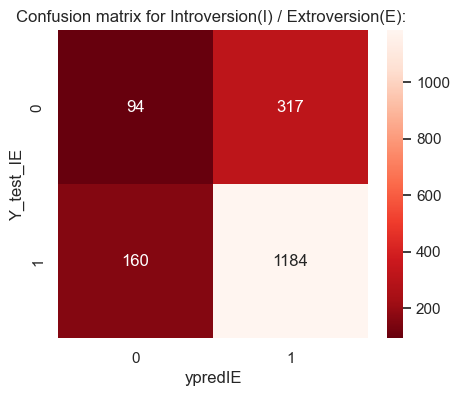

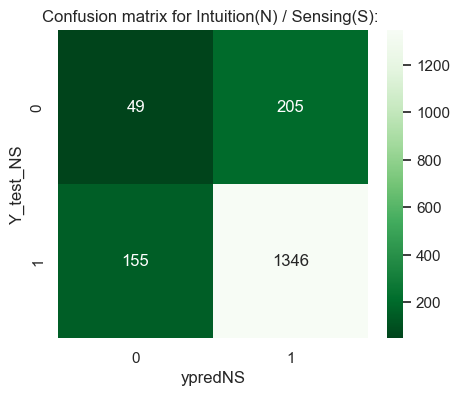

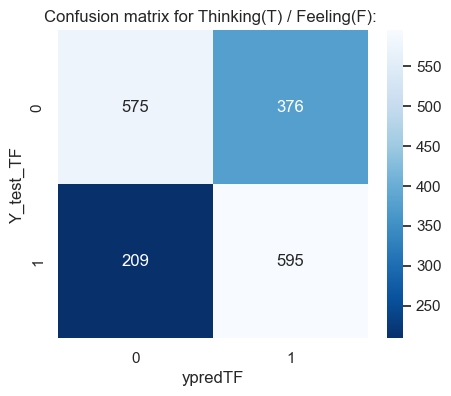

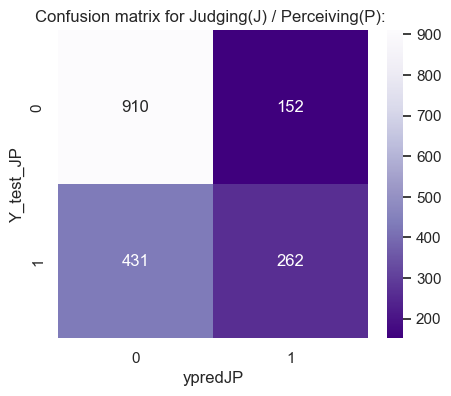

In [113]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

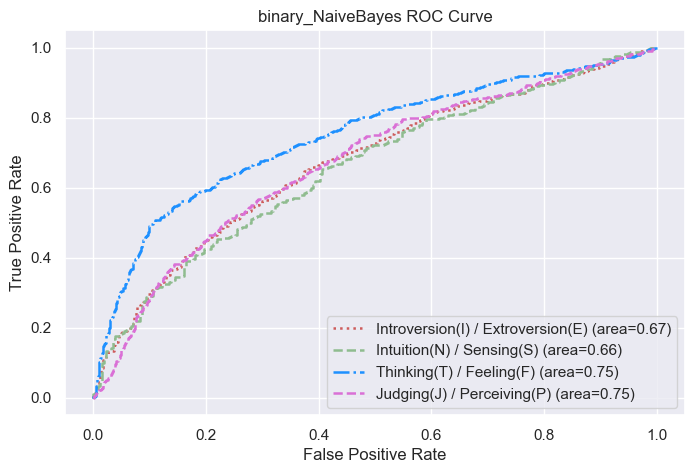

In [115]:
# ROC curve
print_roc_auc_curve(gNB_IE.best_estimator_.predict_proba(X_test_IE),
                    gNB_NS.best_estimator_.predict_proba(X_test_NS),
                    gNB_TF.best_estimator_.predict_proba(X_test_TF),
                    gNB_JP.best_estimator_.predict_proba(X_test_JP),
                    title='binary_NaiveBayes')

#### Logistic Regression

In [116]:
log = LogisticRegression(random_state=42,max_iter=500)
# Fit
log_IE, log_NS, log_TF, log_JP = fitCV(log)
# Prediction
ypredIE, ypredNS, ypredTF, ypredJP = predictCV(log_IE,log_NS,log_TF,log_JP)
# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.60      0.07      0.12       411
           1       0.78      0.99      0.87      1344

    accuracy                           0.77      1755
   macro avg       0.69      0.53      0.50      1755
weighted avg       0.73      0.77      0.69      1755


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.89      0.03      0.06       254
           1       0.86      1.00      0.92      1501

    accuracy                           0.86      1755
   macro avg       0.87      0.52      0.49      1755
weighted avg       0.86      0.86      0.80      1755


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       951
           1       0.77      0.78      0.78       804

    accuracy

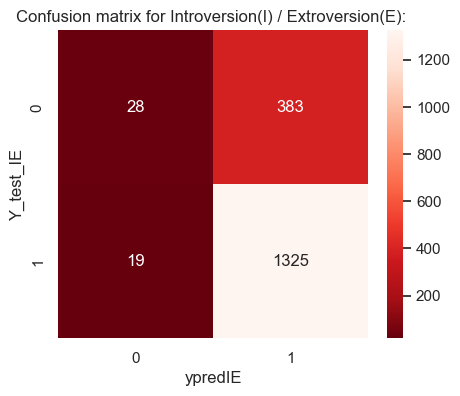

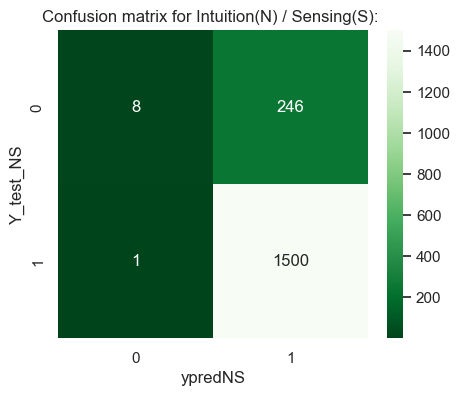

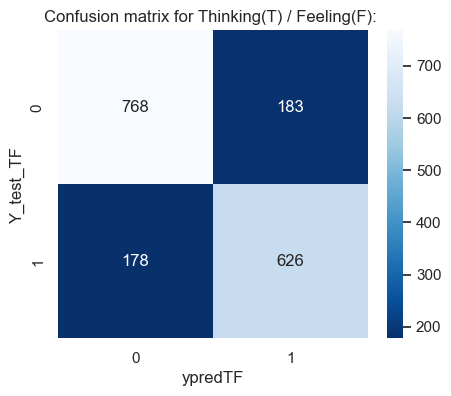

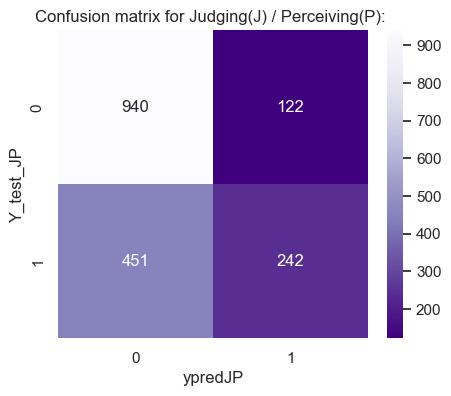

In [117]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

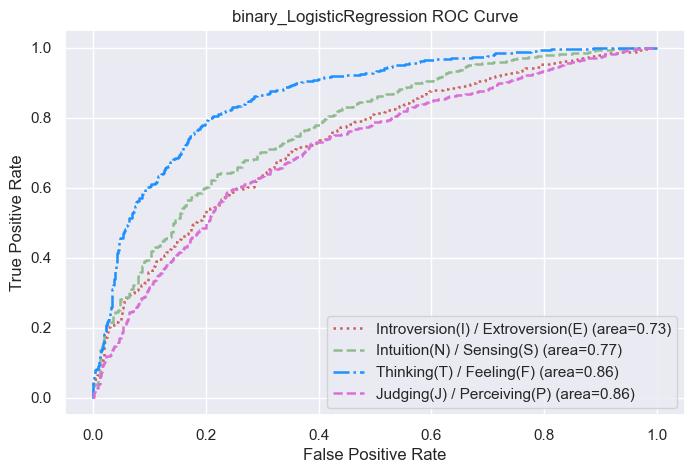

In [118]:
# ROC curve
print_roc_auc_curve(log_IE.best_estimator_.predict_proba(X_test_IE),
                    log_NS.best_estimator_.predict_proba(X_test_NS),
                    log_TF.best_estimator_.predict_proba(X_test_TF),
                    log_JP.best_estimator_.predict_proba(X_test_JP),
                    title='binary_LogisticRegression')

#### SVM

In [119]:
svm = SVC(random_state=42, probability=True)
# Fit
svm_IE, svm_NS, svm_TF, svm_JP = fitCV(svm)
# Prediction
ypredIE, ypredNS, ypredTF, ypredJP = predictCV(svm_IE,svm_NS,svm_TF,svm_JP)
# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.48      0.03      0.05       411
           1       0.77      0.99      0.87      1344

    accuracy                           0.77      1755
   macro avg       0.62      0.51      0.46      1755
weighted avg       0.70      0.77      0.68      1755


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.85      0.04      0.08       254
           1       0.86      1.00      0.92      1501

    accuracy                           0.86      1755
   macro avg       0.85      0.52      0.50      1755
weighted avg       0.86      0.86      0.80      1755


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.80      0.81      0.80       951
           1       0.77      0.76      0.77       804

    accuracy

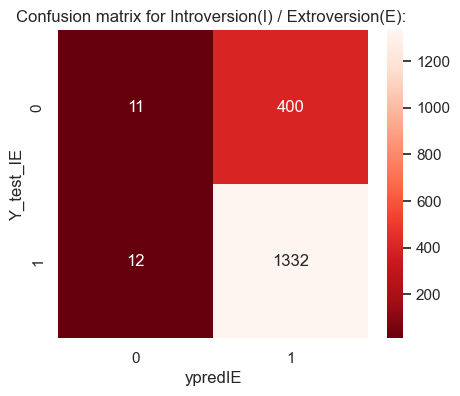

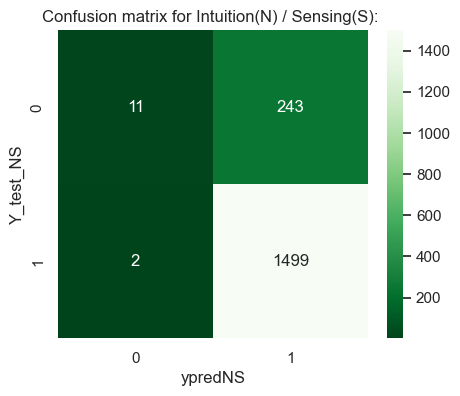

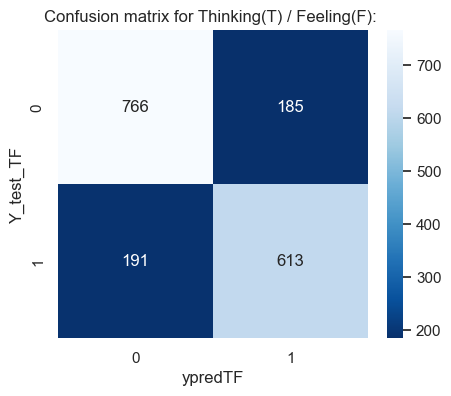

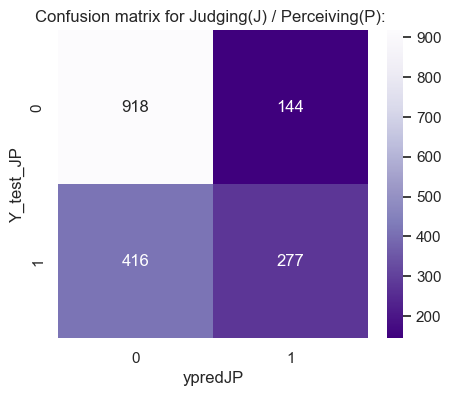

In [120]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

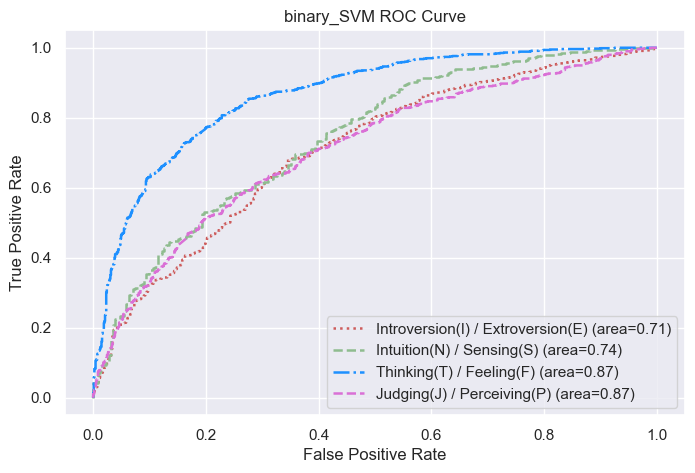

In [121]:
# ROC curve
print_roc_auc_curve(svm_IE.best_estimator_.predict_proba(X_test_IE),
                    svm_NS.best_estimator_.predict_proba(X_test_NS),
                    svm_TF.best_estimator_.predict_proba(X_test_TF),
                    svm_JP.best_estimator_.predict_proba(X_test_JP),
                    title='binary_SVM')

#### K-Nearest Neighbor (KNN)

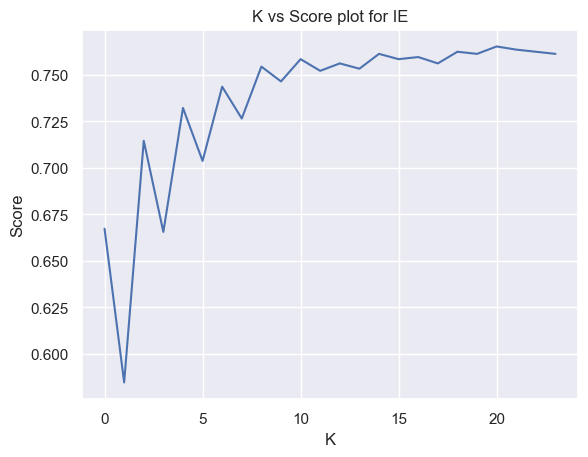

Maximum Accuracy of 0.7652421652421653 at k=21


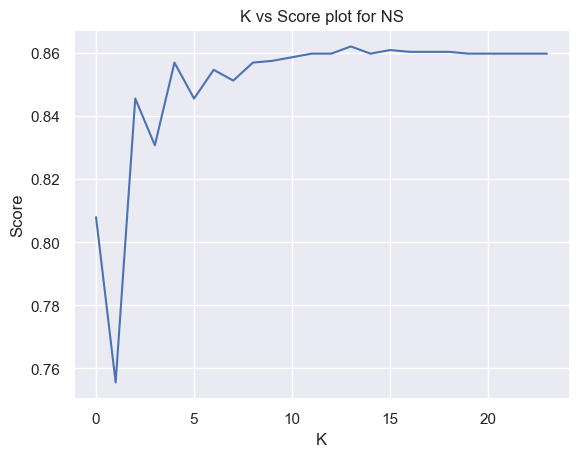

Maximum Accuracy of 0.8621082621082621 at k=14


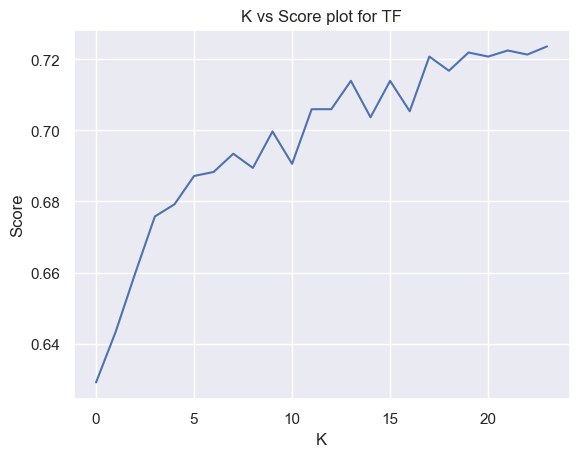

Maximum Accuracy of 0.7236467236467237 at k=24


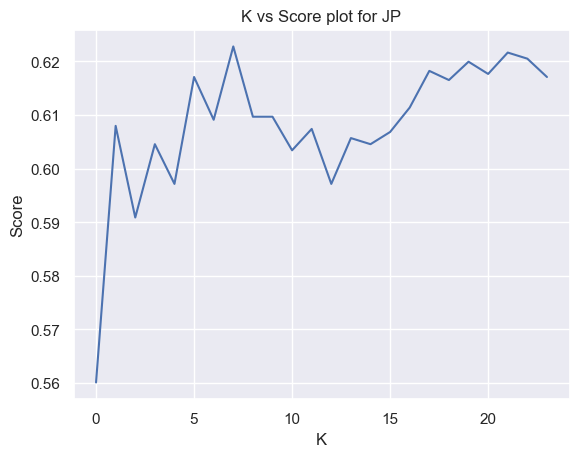

Maximum Accuracy of 0.7236467236467237 at k=24


In [122]:
def plot_graph(val,xlab,ylab,title):
    plt.figure()
    plt.plot(val)
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.title(title)
    plt.show()

# IE prediction
k1_score = []
for i in range(1,25):
    k1 = KNeighborsClassifier(n_neighbors=i)
    k1.fit(X_train_IE, Y_train_IE)
    k1_score.append(k1.score(X_test_IE, Y_test_IE))

df1 = pd.DataFrame(k1_score,columns=['IE'])
plot_graph(k1_score,'K','Score','K vs Score plot for IE')
print(f'Maximum Accuracy of {df1.max()[0]} at k={df1.idxmax()[0]+1}')

# NS prediction
k2_score = []
for i in range(1,25):
	k2 = KNeighborsClassifier(n_neighbors=i)
	k2.fit(X_train_NS, Y_train_NS)
	k2_score.append(k2.score(X_test_NS, Y_test_NS))

df2 = pd.DataFrame(k2_score,columns=['NS'])
plot_graph(k2_score,'K','Score','K vs Score plot for NS')
print(f'Maximum Accuracy of {df2.max()[0]} at k={df2.idxmax()[0]+1}')

# TF prediction
k3_score = []
for i in range(1,25):
  k3 = KNeighborsClassifier(n_neighbors=i)
  k3.fit(X_train_TF, Y_train_TF)
  k3_score.append(k3.score(X_test_TF, Y_test_TF))

df3 = pd.DataFrame(k3_score,columns=['TF'])
plot_graph(k3_score,'K','Score','K vs Score plot for TF')
print(f'Maximum Accuracy of {df3.max()[0]} at k={df3.idxmax()[0]+1}')

# JP prediction
k4_score=[]
for i in range(1,25):
  k4 = KNeighborsClassifier(n_neighbors=i)
  k4.fit(X_train_JP, Y_train_JP)
  k4_score.append(k4.score(X_test_JP, Y_test_JP))

df4 = pd.DataFrame(k3_score,columns=['JP'])
plot_graph(k4_score,'K','Score','K vs Score plot for JP')
print(f'Maximum Accuracy of {df4.max()[0]} at k={df4.idxmax()[0]+1}')

In [123]:
kbestIE = KNeighborsClassifier(n_neighbors=df1.idxmax()[0]+1)
knn_IE = kbestIE.fit(X_train_IE,Y_train_IE)
ypredIE = knn_IE.predict(X_test_IE)

kbestNS = KNeighborsClassifier(n_neighbors=df2.idxmax()[0]+1)
knn_NS = kbestNS.fit(X_train_NS,Y_train_NS)
ypredNS = knn_NS.predict(X_test_NS)

kbestTF = KNeighborsClassifier(n_neighbors=df3.idxmax()[0]+1)
knn_TF = kbestTF.fit(X_train_TF,Y_train_TF)
ypredTF = knn_TF.predict(X_test_TF)

kbestJP = KNeighborsClassifier(n_neighbors=df4.idxmax()[0]+1)
knn_JP = kbestJP.fit(X_train_JP,Y_train_JP)
ypredJP = knn_JP.predict(X_test_JP)

# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.49      0.05      0.09       411
           1       0.77      0.98      0.87      1344

    accuracy                           0.77      1755
   macro avg       0.63      0.52      0.48      1755
weighted avg       0.71      0.77      0.68      1755


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.77      0.07      0.12       254
           1       0.86      1.00      0.93      1501

    accuracy                           0.86      1755
   macro avg       0.82      0.53      0.52      1755
weighted avg       0.85      0.86      0.81      1755


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.76      0.71      0.74       951
           1       0.68      0.74      0.71       804

    accuracy

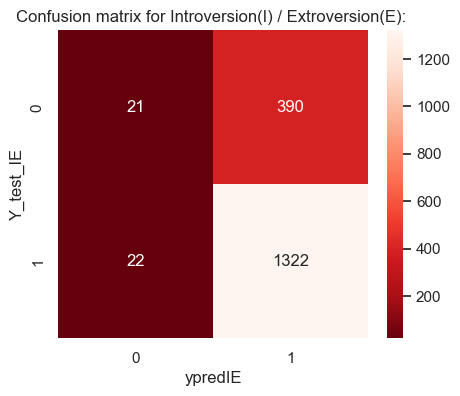

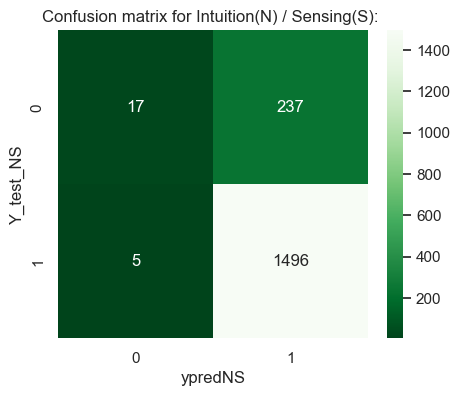

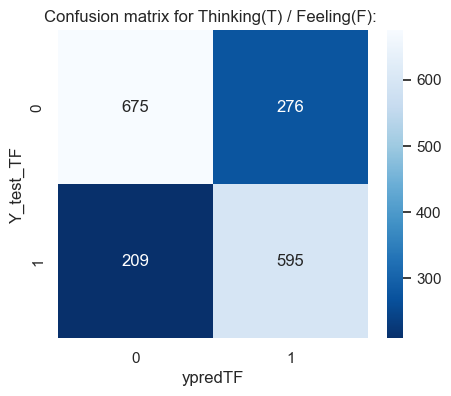

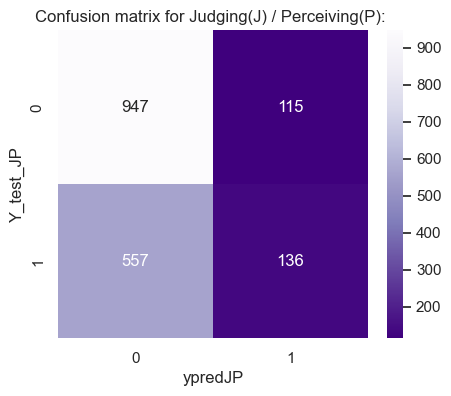

In [124]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

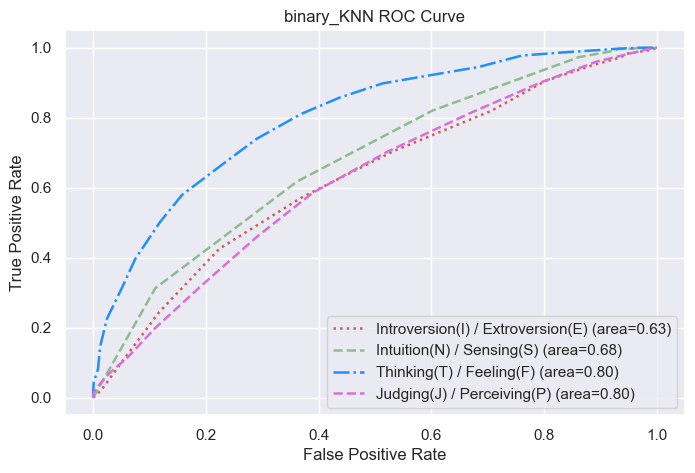

In [125]:
# ROC curve
print_roc_auc_curve(kbestIE.predict_proba(X_test_IE),
                    kbestNS.predict_proba(X_test_NS),
                    kbestTF.predict_proba(X_test_TF),
                    kbestJP.predict_proba(X_test_JP),
                    title='binary_KNN')

#### Decision Tree

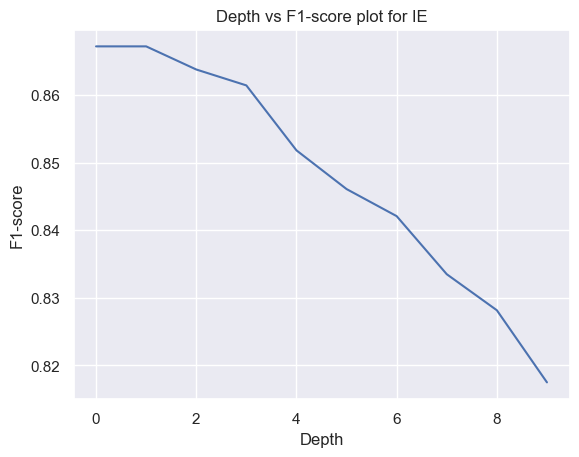

Maximum F1-score of 0.8671936264937905 at depth=1


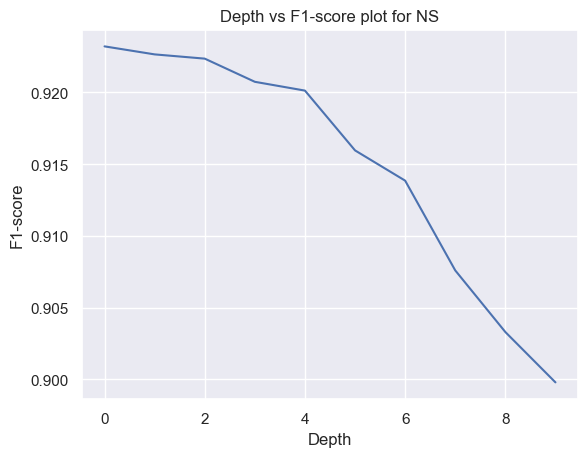

Maximum F1-score of 0.9232085106533268 at depth=1


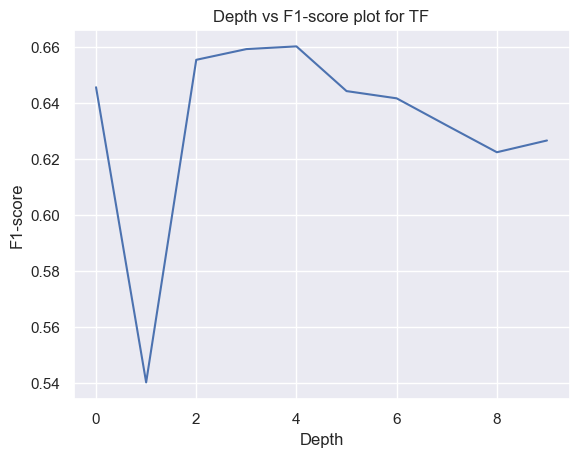

Maximum F1-score of 0.660127981658077 at depth=5


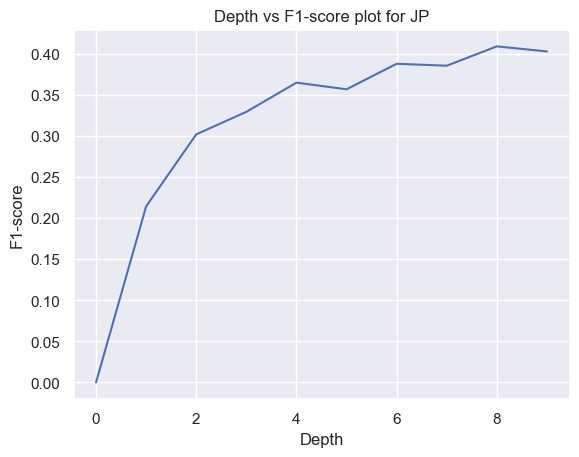

Maximum F1-score of 0.4089722654453579 at depth=9


In [131]:
def plot_graph(val, title):
    plt.plot(val)
    plt.ylabel('F1-score')
    plt.xlabel('Depth')
    plt.title(title)
    plt.show()

# IE prediction
k1_score = []
for i in range(1,11):
    k1_cart = DecisionTreeClassifier(criterion="gini", max_depth=i, random_state=42)
    score = cross_val_score(k1_cart, X_train_IE, Y_train_IE, cv=10, scoring='f1')
    k1_score.append(score.mean())
df1 = pd.DataFrame(k1_score,columns=['IE'])
plot_graph(k1_score,'Depth vs F1-score plot for IE')
print(f'Maximum F1-score of {df1.max()[0]} at depth={df1.idxmax()[0]+1}')

# NS prediction
k2_score = []
for i in range(1,11):
    k2_cart = DecisionTreeClassifier(criterion="gini", max_depth=i, random_state=42)
    score = cross_val_score(k2_cart, X_train_NS, Y_train_NS, cv=10, scoring='f1')
    k2_score.append(score.mean())
df2 = pd.DataFrame(k2_score,columns=['NS'])
plot_graph(k2_score,'Depth vs F1-score plot for NS')
print(f'Maximum F1-score of {df2.max()[0]} at depth={df2.idxmax()[0]+1}')

# TF prediction
k3_score = []
for i in range(1,11):
    k3_cart = DecisionTreeClassifier(criterion="gini", max_depth=i, random_state=42)
    score = cross_val_score(k3_cart, X_train_TF, Y_train_TF, cv=10, scoring='f1')
    k3_score.append(score.mean())
df3 = pd.DataFrame(k3_score,columns=['TF'])
plot_graph(k3_score,'Depth vs F1-score plot for TF')
print(f'Maximum F1-score of {df3.max()[0]} at depth={df3.idxmax()[0]+1}')

# JP prediction
k4_score=[]
for i in range(1,11):
    k4_cart = DecisionTreeClassifier(criterion="gini", max_depth=i, random_state=42)
    score = cross_val_score(k4_cart, X_train_JP, Y_train_JP, cv=10, scoring='f1')
    k4_score.append(score.mean())
df4 = pd.DataFrame(k4_score,columns=['JP'])
plot_graph(k4_score,'Depth vs F1-score plot for JP')
print(f'Maximum F1-score of {df4.max()[0]} at depth={df4.idxmax()[0]+1}')

In [132]:
dtbestIE = DecisionTreeClassifier(criterion="gini", max_depth=df1.idxmax()[0]+1, random_state=42)
dt_IE = dtbestIE.fit(X_train_IE,Y_train_IE)
ypredIE = dt_IE.predict(X_test_IE)

dtbestNS = DecisionTreeClassifier(criterion="gini", max_depth=df2.idxmax()[0]+1, random_state=42)
dt_NS = dtbestNS.fit(X_train_NS,Y_train_NS)
ypredNS = dt_NS.predict(X_test_NS)

dtbestTF = DecisionTreeClassifier(criterion="gini", max_depth=df3.idxmax()[0]+1, random_state=42)
dt_TF = dtbestTF.fit(X_train_TF,Y_train_TF)
ypredTF = dt_TF.predict(X_test_TF)

dtbestJP = DecisionTreeClassifier(criterion="gini", max_depth=df4.idxmax()[0]+1, random_state=42)
dt_JP = dtbestJP.fit(X_train_JP,Y_train_JP)
ypredJP = dt_JP.predict(X_test_JP)

# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       411
           1       0.77      1.00      0.87      1344

    accuracy                           0.77      1755
   macro avg       0.38      0.50      0.43      1755
weighted avg       0.59      0.77      0.66      1755


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.75      0.04      0.07       254
           1       0.86      1.00      0.92      1501

    accuracy                           0.86      1755
   macro avg       0.80      0.52      0.50      1755
weighted avg       0.84      0.86      0.80      1755


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.71      0.72      0.72       951
           1       0.66      0.65      0.66       804

    accuracy

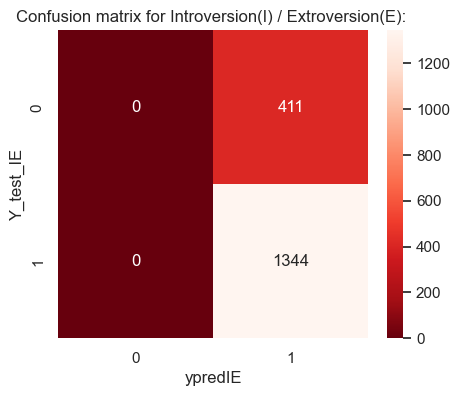

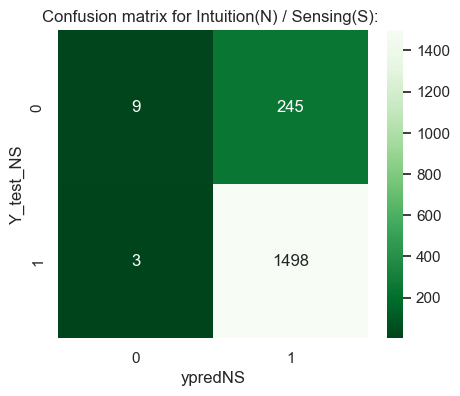

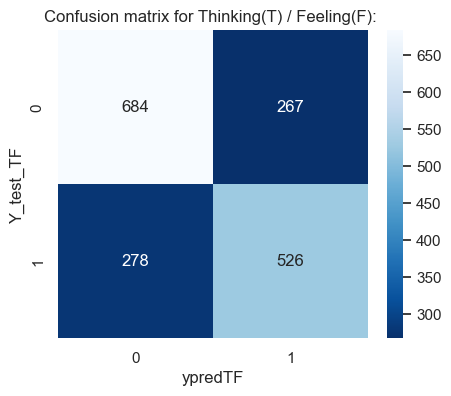

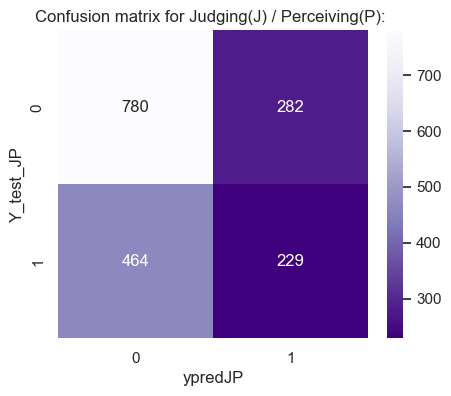

In [133]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

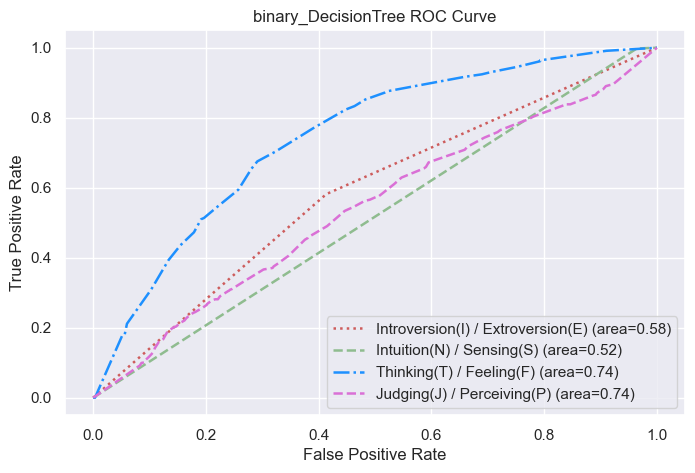

In [134]:
# ROC curve
print_roc_auc_curve(dtbestIE.predict_proba(X_test_IE),
                    dtbestNS.predict_proba(X_test_NS),
                    dtbestTF.predict_proba(X_test_TF),
                    dtbestJP.predict_proba(X_test_JP),
                    title='binary_DecisionTree')

#### Random Forest

In [135]:
rf = RandomForestClassifier(n_estimators=200,  # after tuning
                            random_state=42)
# Fit
rf_IE, rf_NS, rf_TF, rf_JP = fitCV(rf)
# Prediction
ypredIE, ypredNS, ypredTF, ypredJP = predictCV(rf_IE,rf_NS,rf_TF,rf_JP)
# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.48      0.04      0.07       411
           1       0.77      0.99      0.87      1344

    accuracy                           0.77      1755
   macro avg       0.63      0.51      0.47      1755
weighted avg       0.70      0.77      0.68      1755


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.67      0.03      0.06       254
           1       0.86      1.00      0.92      1501

    accuracy                           0.86      1755
   macro avg       0.76      0.51      0.49      1755
weighted avg       0.83      0.86      0.80      1755


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.74      0.82      0.78       951
           1       0.75      0.66      0.71       804

    accuracy

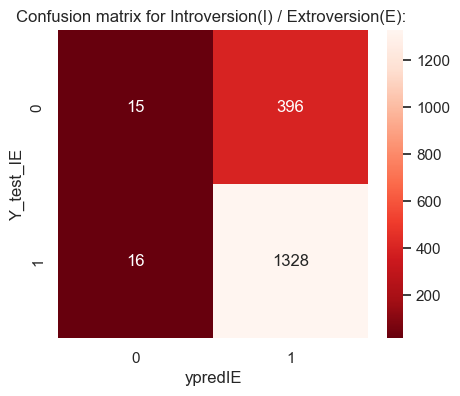

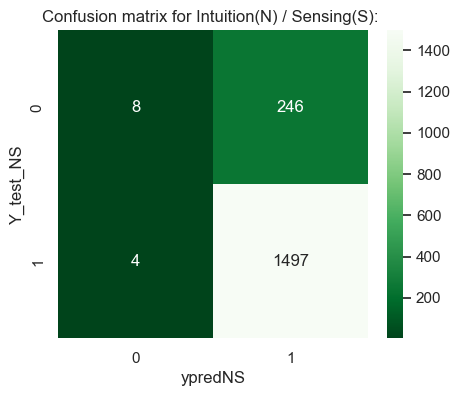

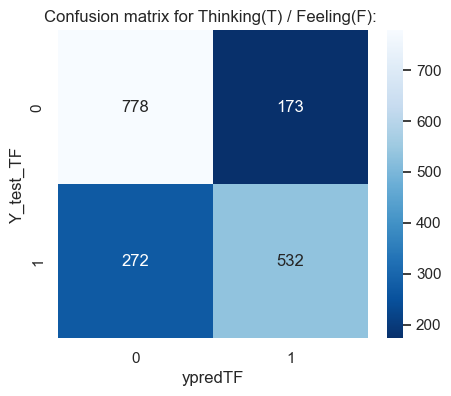

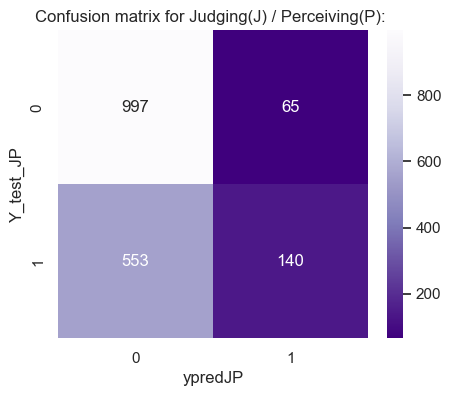

In [136]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

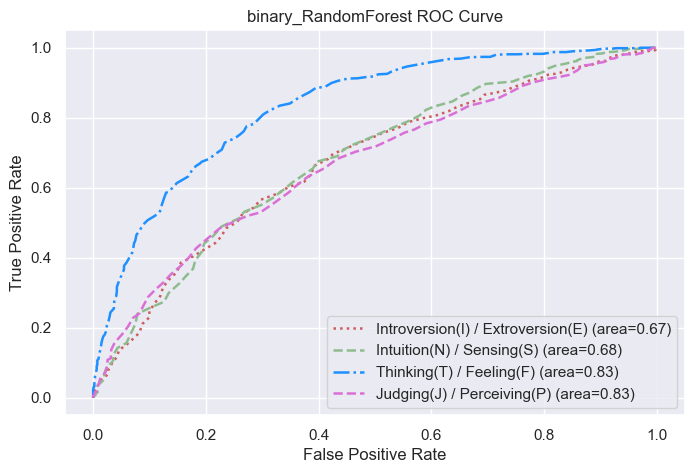

In [137]:
# ROC curve
print_roc_auc_curve(rf_IE.best_estimator_.predict_proba(X_test_IE),
                    rf_NS.best_estimator_.predict_proba(X_test_NS),
                    rf_TF.best_estimator_.predict_proba(X_test_TF),
                    rf_JP.best_estimator_.predict_proba(X_test_JP),
                    title='binary_RandomForest')

#### Gradient Boost

In [138]:
gb = GradientBoostingClassifier(random_state=42)
# Fit
gb_IE, gb_NS, gb_TF, gb_JP = fitCV(gb)
# Prediction
ypredIE, ypredNS, ypredTF, ypredJP = predictCV(gb_IE,gb_NS,gb_TF,gb_JP)
# Print classification report
print_classification_report(ypredIE, ypredNS, ypredTF, ypredJP)

Classification Report for Introversion(I) / Extroversion(E):
               precision    recall  f1-score   support

           0       0.48      0.08      0.13       411
           1       0.78      0.97      0.86      1344

    accuracy                           0.76      1755
   macro avg       0.63      0.53      0.50      1755
weighted avg       0.71      0.76      0.69      1755


Classification Report for Intuition(N) / Sensing(S):
               precision    recall  f1-score   support

           0       0.54      0.06      0.11       254
           1       0.86      0.99      0.92      1501

    accuracy                           0.86      1755
   macro avg       0.70      0.53      0.51      1755
weighted avg       0.81      0.86      0.80      1755


Classification Report for Thinking(T) / Feeling(F):
              precision    recall  f1-score   support

           0       0.77      0.78      0.77       951
           1       0.74      0.72      0.73       804

    accuracy

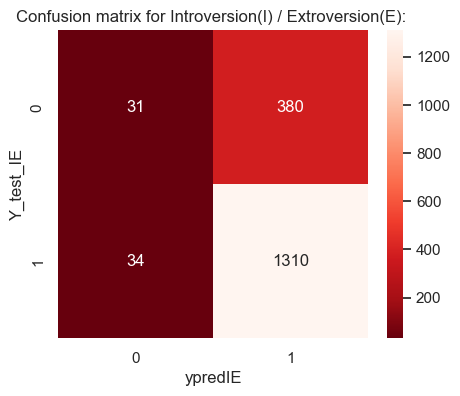

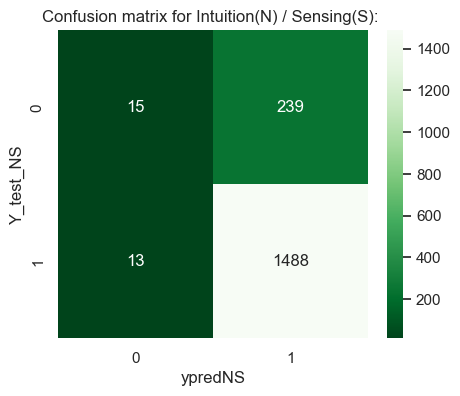

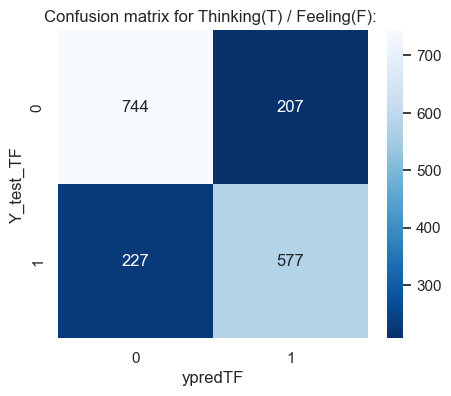

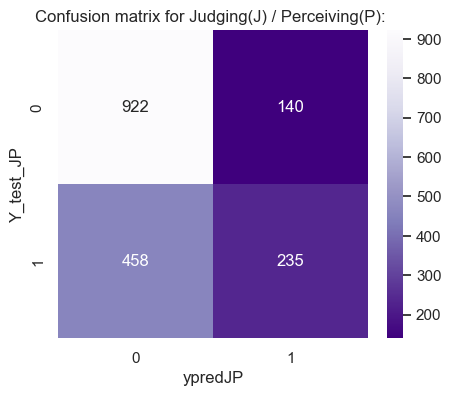

In [139]:
# Confusion matrix
print_confusion_matrix(ypredIE, ypredNS, ypredTF, ypredJP)

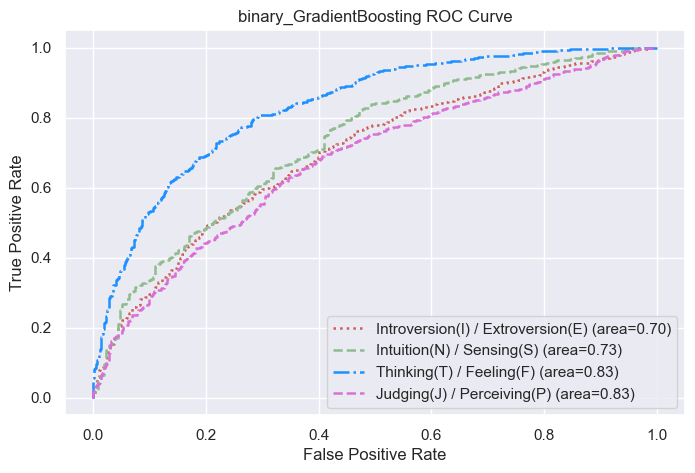

In [140]:
# ROC curve
print_roc_auc_curve(gb_IE.best_estimator_.predict_proba(X_test_IE),
                    gb_NS.best_estimator_.predict_proba(X_test_NS),
                    gb_TF.best_estimator_.predict_proba(X_test_TF),
                    gb_JP.best_estimator_.predict_proba(X_test_JP),
                    title='binary_GradientBoosting')

## Test on Celebrity dataset
利用名人 Twitter 資料集來預測陌生資料的 MBTI

### Preprocess

In [146]:
# # If you didn't install emoji before:
# !pip install emoji --upgrade
import emoji

In [179]:
def combineRow(data):
	tweet_data = []  
	tmp = data.copy()
	m = tmp['tweet'].str.contains('\w+')
	tmp_ = tmp[m].groupby((~m).cumsum(), as_index=False).agg(', '.join)
	tweet_data.append(tmp_)
	tweet_data = pd.concat(tweet_data)
	return tweet_data

def processEmoji(data):
	for i in range(len(data)):
		post = data.at[i, 'tweet']
		result = re.findall(r'\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[0-9][0-9]\\x[A-Za-z][0-9]\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[0-9][0-9]\\x[A-Za-z][0-9]|\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[0-9][A-Za-z]\\x[A-Za-z][0-9]|\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[0-9][0-9]\\x[A-Za-z][0-9]|\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[0-9][0-9]\\x[0-9][0-9]|\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]|\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[0-9][0-9]\\x[0-9][A-Za-z]|\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[0-9][0-9]\\x[A-Za-z][A-Za-z]|\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]\\x[A-Za-z][0-9]\\x[A-Za-z][0-9]|\\x[A-Za-z][0-9]\\x[0-9][0-9]\\x[0-9][0-9]|\\x[A-Za-z][0-9]\\x[0-9][0-9]\\x[A-Za-z][0-9]\\x[A-Za-z][A-Za-z]\\x[A-Za-z][0-9]\\x[0-9][A-Za-z]|\\x[A-Za-z][0-9]\\x[0-9][0-9]\\x[0-9][A-Za-z]', post)
		string_ = []
		for j in result:
			string_.append(j.encode().decode('unicode_escape').encode("raw_unicode_escape"))
			emoji_list = []
		for k in string_:
			emoji_list.append(k.decode("utf-8", errors='ignore'))
			emoji_text = []
		for m in range(len(emoji_list)):
			emoji_text.append(emoji.demojize(emoji_list[m]))
			post_list = []
		for l in range(len(result)):
			post = post.replace(result[l] , emoji_text[l])
			data.tweet[i] = post
	return data

def Preprocessor_test(text):
    # Cleaning
    text = re.sub(r'\|\|\|', ' ', text)  # Split by separator
    text = re.sub(r'http\S+', ' ', text)  # Replace hyperlink
    text = re.sub(r'\d',' ', text)  # 去除數字
    text = re.sub(r'^b\'', ' ', text) 
    text = re.sub(r"[A-Za-z]+\'+\w+", ' ', text)  # Handling apostrophe (e.g. you've, there's)
    text = re.sub(r'x[A-Za-z]', ' ', text)
    text = re.sub(r'\b[A-Za-z]\b', ' ', text)
    text = re.sub(r"\@+[A-Za-z]+\w+", ' ', text)
    text = re.sub(r'\bR[A-Z]\b', ' ', text)
    text = re.sub(r'[.,"\'\-?:!;@#&()]', ' ', text)
    text = re.sub(r'\\',' ', text)
    text = re.sub(r'[’“”/]', ' ', text)
    # text = re.sub('[^0-9a-zA-Z]',' ', text)  # Keep only numbers and alphabets (remove special characters)
    # text = re.sub(r'\b[A-Za-z]\b', ' ', text)
    text = text.lower()
    text = re.sub('intj|intp|entj|entp|infp|enfj|enfp|istj|isfj|estj|esfj|istp|isfp|estp|esfp|infj', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    filtered_tokens = [w for w in tokens if not w in stopwords.words('english')]  # Remove stopwords
    # Stemming
    stemmer_ = SnowballStemmer("english")
    stemmed = [stemmer_.stem(t) for t in filtered_tokens]
    # Lemmatizing
    lemma = WordNetLemmatizer()
    lemmatized = " ".join([lemma.lemmatize(w) for w in stemmed])
    return lemmatized

def test_text(data):
	for i in range(len(data)):
		post = data.loc[i, 'tweet']

		text = Preprocessor_test(post)

		data.tweet[i] = text
	return data

預測會用到的 function

In [194]:
modelList = {'gNB': [gNB_IE, gNB_NS, gNB_TF, gNB_JP],
            'log': [log_IE, log_NS, log_TF, log_JP],
            'svm': [svm_IE, svm_NS, svm_TF, svm_JP],
            'knn': [knn_IE, knn_NS, knn_TF, knn_JP],
            'dt': [dt_IE, dt_NS, dt_TF, dt_JP],
            'rf': [rf_IE, rf_NS, rf_TF, rf_JP],
            'gb': [gb_IE, gb_NS, gb_TF, gb_JP]}

### Case 1 Adele: ENTJ

In [234]:
def predictMBTI(model:str , svd):
    pred_IE = modelList[str(model)][0].predict(svd)
    pred_NS = modelList[str(model)][1].predict(svd)
    pred_TF = modelList[str(model)][2].predict(svd)
    pred_JP = modelList[str(model)][3].predict(svd)
    
    char = []  # list for storing result
    char.append('I') if pred_IE else char.append('E')
    char.append('N') if pred_NS else char.append('S')
    char.append('T') if pred_TF else char.append('F')
    char.append('J') if pred_JP else char.append('P')

    return ''.join(char)

In [163]:
df_adele = pd.read_csv('../data/Adele.csv')
df_adele

,twitter_id,date,tweet
0,1543973875687596033,2022-07-04 15:03:52+00:00,b'Thank you to my band and my crew for two sea...
1,1543973499508752386,2022-07-04 15:02:22+00:00,b'Hyde Park Night 2! My heart is absolutely fu...
2,1543254652807954439,2022-07-02 15:25:56+00:00,"b'Thank you my loves, I can\xe2\x80\x99t wait ..."
3,1543254498247835648,2022-07-02 15:25:19+00:00,b'Hyde Park Night 1! What a crowd!! https://t....
4,1542530240060194816,2022-06-30 15:27:22+00:00,b'Who\xe2\x80\x99s ready for tomorrow!? https:...
...,...,...,...
360,29513802932,2010-11-02 22:54:44+00:00,b'RT @ColumbiaRecords: NEWS: Adele @OfficialAd...
361,29419669509,2010-11-02 00:05:24+00:00,"b""Head over to Adele's newly re-designed websi..."
362,29104016829,2010-10-29 16:37:36+00:00,b'Adele has a new blog up at http://www.adele....
363,27248872792,2010-10-13 14:58:33+00:00,b'Adele has a new blog up at her website. Chec...


In [180]:
adele_data = combineRow(df_adele)
adele_data = processEmoji(adele_data)
adele_data = test_text(adele_data)

In [183]:
adele_tfidf = vectorizer.transform(adele_data.tweet)
adele_svd = svd.transform(adele_tfidf)

In [231]:
predictMBTI('svm', adele_svd)

'ESFP'

In [235]:
for idx, (k,v) in enumerate(modelList.items()):
    print(f'Result from model {k}: {predictMBTI(k, adele_svd)}')

Result from model gNB: ESFP
Result from model log: INFP
Result from model svm: ESFP
Result from model knn: ESFJ
Result from model dt: INFP
Result from model rf: ENFP
Result from model gb: ESFP


正確答案是 ENTJ

### Case 2 Anna Kendrick: ENTP

In [217]:
df_anna = pd.read_csv('../data/AnnaKendrick47.csv')
df_anna

,twitter_id,date,tweet
0,1538329814771408896,2022-06-19 01:16:23+00:00,b'@billyeichner @ecareyo Billy!! If you keep t...
1,1538263976689246208,2022-06-18 20:54:46+00:00,b'@billyeichner We can finally live our truth ...
2,1495591654828687363,2022-02-21 02:50:11+00:00,"b'@LouisPeitzman Sir, please do not come for o..."
3,1495470771736514563,2022-02-20 18:49:51+00:00,b'@joshgondelman That\xe2\x80\x99s only becaus...
4,1495167995911360512,2022-02-19 22:46:43+00:00,b'@trixiemattel @Barbie \xf0\x9f\x92\x95\xf0\x...
...,...,...,...
2463,2880005300,2009-07-27 23:47:51+00:00,b'3.To clarify: annakendrick47 is my FIRST & o...
2464,2879979190,2009-07-27 23:46:09+00:00,b'2.Was asked why I didn\xe2\x80\x99t just hav...
2465,2879943758,2009-07-27 23:43:50+00:00,b'1.Must give a big thanks to Rachelle Lefevre...
2466,2831350530,2009-07-25 03:10:40+00:00,b'Seeeeee....... (this is the only twitter I h...


In [218]:
anna_data = combineRow(df_anna)
anna_data = processEmoji(anna_data)
anna_data = test_text(anna_data)
anna_tfidf = vectorizer.transform(anna_data.tweet)
anna_svd = svd.transform(anna_tfidf)

In [220]:
for idx, (k,v) in enumerate(modelList.items()):
    print(f'Result from model {k}: {predictMBTI(k, anna_svd)}')

Result from model gNB: ESFP
Result from model log: ENFP
Result from model svm: ENTP
Result from model knn: ENFP
Result from model dt: ISFP
Result from model rf: ENFP
Result from model gb: ENTP
